In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

In [5]:
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/AIQuest/課題4'
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/AIQuest/課題4
/content/drive/MyDrive/Colab Notebooks/AIQuest/課題4


In [6]:
sales = pd.read_csv('sales_history.csv')
cats = pd.read_csv('item_categories.csv')
cat_names = pd.read_csv('category_names.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv', header=None)

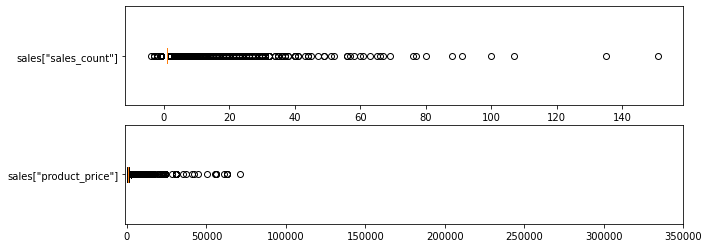

In [7]:
fig, ax = plt.subplots(2,1,figsize=(10,4))

plt.xlim(-300, 3000)
ax[0].boxplot((sales['売上個数']) , labels=['sales["sales_count"]'], vert=False)

plt.xlim(-1000, 350000)
ax[1].boxplot((sales['商品価格']) , labels=['sales["product_price"]'], vert=False)
plt.show()

In [8]:
sales = sales[sales['売上個数']<120]

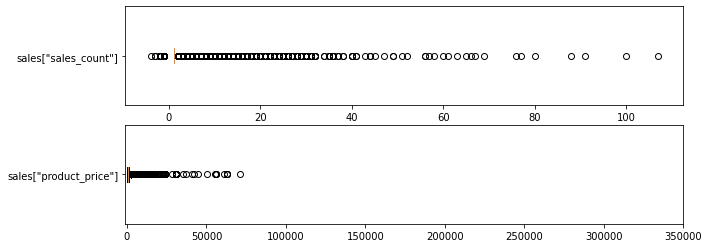

In [9]:
fig, ax = plt.subplots(2,1,figsize=(10,4))

plt.xlim(-300, 3000)
ax[0].boxplot((sales['売上個数']) , labels=['sales["sales_count"]'], vert=False)

plt.xlim(-1000, 350000)
ax[1].boxplot((sales['商品価格']) , labels=['sales["product_price"]'], vert=False)
plt.show()

In [10]:
sales = pd.merge(sales, cats, on='商品ID', how='left')
sales = pd.merge(sales, cat_names, on='商品カテゴリID', how='left')

# sales

In [11]:
# 「日付」カラムの文字列から、「年」「月」の情報を抽出する
sales['年'] = sales['日付'].apply(lambda x: x.split('-')[0])
sales['月'] = sales['日付'].apply(lambda x: x.split('-')[1])
sales['年'] = sales['年'].astype(int)
sales['月'] = sales['月'].astype(int)

# sales

In [12]:
gp_month = sales.groupby(['年', '月', '商品ID', '店舗ID']).agg({'売上個数': np.sum}).reset_index()
# gp_month

In [13]:
gp = gp_month.groupby(['商品ID', '店舗ID']).agg({'売上個数': np.sum}).reset_index()
# gp

In [14]:
g = gp.groupby(['商品ID', '店舗ID']).agg({'売上個数': np.average}).reset_index()
# g

In [15]:
gtmp = g[:len(test)]
# gtmp

In [16]:
test['売上予測'] = 0

In [ ]:
for i in range(len(test)):
    print(i)
    for j in range(len(gtmp)):
        if (test['商品ID'][i] == gtmp['商品ID'][j]) & (test['店舗ID'][i] == gtmp['店舗ID'][j]):
            test['売上予測'][i] = gtmp['売上個数'][j]

In [19]:
train = sales.drop(['日付', '商品カテゴリID', '商品カテゴリ名', '商品価格'], axis=1)
# train

In [20]:
test['年'] = 2019
test['月'] = 12
# test

In [21]:
x = train.drop('売上個数', axis=1)
y = train['売上個数']

In [22]:
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.2, random_state=2021)

In [25]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train) 

In [26]:
# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的 : 回帰  
        'metric': {'rmse'}, # 評価指標 : rsme(平均二乗誤差の平方根) 
        'learning_rate': 0.1,
        'num_leaves': 100,
        'min_data_in_leaf': 1,
        'num_iteration': 1000, #1000回学習
        'verbose': 0
}

# モデルの学習
model = lgb.train(params, # パラメータ
            train_set=lgb_train, # トレーニングデータの指定
            valid_sets=lgb_eval, # 検証データの指定
            early_stopping_rounds=100 # 100回ごとに検証精度の改善を検討　→ 精度が改善しないなら学習を終了(過学習に陥るのを防ぐ)
               )

# テストデータの予測
y_pred = model.predict(x_test)

[1]	valid_0's rmse: 0.783586
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.779083
[3]	valid_0's rmse: 0.774994
[4]	valid_0's rmse: 0.771787
[5]	valid_0's rmse: 0.769024
[6]	valid_0's rmse: 0.767041
[7]	valid_0's rmse: 0.765162
[8]	valid_0's rmse: 0.763867
[9]	valid_0's rmse: 0.762732
[10]	valid_0's rmse: 0.761216
[11]	valid_0's rmse: 0.759993
[12]	valid_0's rmse: 0.758946
[13]	valid_0's rmse: 0.758026
[14]	valid_0's rmse: 0.757202
[15]	valid_0's rmse: 0.756575
[16]	valid_0's rmse: 0.755876
[17]	valid_0's rmse: 0.755451
[18]	valid_0's rmse: 0.754912
[19]	valid_0's rmse: 0.754516
[20]	valid_0's rmse: 0.754054
[21]	valid_0's rmse: 0.753669
[22]	valid_0's rmse: 0.753331
[23]	valid_0's rmse: 0.752912
[24]	valid_0's rmse: 0.752573
[25]	valid_0's rmse: 0.752286
[26]	valid_0's rmse: 0.751861
[27]	valid_0's rmse: 0.751545
[28]	valid_0's rmse: 0.751305
[29]	valid_0's rmse: 0.751136
[30]	valid_0's rmse: 0.750796
[31]	valid_0's rmse: 0.750576
[32]	valid_0's r

In [27]:
# モデル評価
# rmse : 平均二乗誤差の平方根
mse = mean_squared_error(y_test, y_pred) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) # RSME = √MSEの算出
print('RMSE :',rmse)

#r2 : 決定係数
r2 = r2_score(y_test,y_pred)
print('R2 :',r2)

RMSE : 0.7452483589499689
R2 : 0.10906153811593322


In [28]:
X_test = test.drop('index', axis=1)
# X_test

In [29]:
y_pred = model.predict(X_test)

In [33]:
sub.iloc[:, -1] = y_pred

# sub

In [32]:
# sub.to_csv('my_submission2.csv', index=False, header=False)